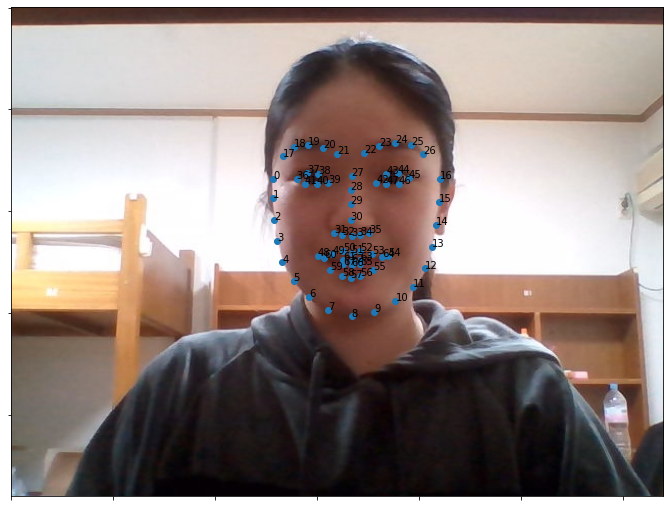

In [10]:
import os
import time
import numpy as np
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

#read the picture
image_path = 'picture/user_frame.jpg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
rects = detector(image, 1)

#make  frame
for rect in rects:
    landmarks = np.matrix([[p.x, p.y] for p in predictor(image, rect).parts()])
fig, ax = plt.subplots(figsize=(16,9))
frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#shape_predictor_68_face_landmarks
for d in rects:
    parts = predictor(frame, d).parts()
    ax.scatter([point.x for point in parts], [point.y for point in parts])
    for k, point in enumerate(parts):
        ax.text(point.x, point.y, k)
    ax.imshow(frame)
    plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
    plt.show()

In [11]:
# calculate the ratio of face parts

#Aspect Ratio,comparison of face length and width.The wider the width, the higher the value
def fwhrs(parts):
    height = ((parts[8].x - parts[27].x) ** 2 + (parts[8].y - parts[27].y) ** 2) ** 0.5
    width = ((parts[16].x - parts[0].x) ** 2 + (parts[16].y - parts[0].y) ** 2) ** 0.5
    fwhr = width/height
    return round(fwhr, 3)

#the ratio of the distance between the eyebrow and the nose, the nose and the tip of the chin
def heights(parts):
    top_height = ((parts[33].x - parts[27].x) ** 2 + (parts[33].y - parts[27].y) ** 2) ** 0.5
    bottom_height =((parts[8].x - parts[33].x) ** 2 + (parts[8].y - parts[33].y) ** 2) ** 0.5
    return top_height,bottom_height

#distance from the edge of the face to the corner of the left eye.....etc.
def widths(parts):
    left_face = ((parts[16].x - parts[45].x) ** 2 + (parts[16].y - parts[45].y) ** 2) ** 0.5
    left_eye = ((parts[45].x - parts[42].x) ** 2 + (parts[45].y - parts[42].y) ** 2) ** 0.5
    middle_face = ((parts[42].x - parts[39].x) ** 2 + (parts[42].y - parts[39].y) ** 2) ** 0.5
    right_eye = ((parts[39].x - parts[36].x) ** 2 + (parts[39].y - parts[36].y) ** 2) ** 0.5
    right_face = ((parts[36].x - parts[0].x) ** 2 + (parts[36].y - parts[0].y) ** 2) ** 0.5
    return left_face, left_eye, middle_face, right_eye,right_face

#distance between nose and lower lip, distance between the lower lip and the tip of the chin
def mouses(parts):
    top_mouse = ((parts[57].x - parts[33].x) ** 2 + (parts[57].y - parts[33].y) ** 2) ** 0.5
    bottom_mouse = ((parts[8].x - parts[57].x) ** 2 + (parts[8].y - parts[57].y) ** 2) ** 0.5
    return top_mouse, bottom_mouse

#make data frame
df = pd.DataFrame()

#figure out the ratio
for file_name in os.listdir('picture'):
    if file_name[-4:] != '.jpg':
        continue
    
    if file_name == "user_frame.jpg": continue
    
    frame = cv2.imread('picture/'+file_name)
    dets = detector(frame[:, :, ::-1])
    if len(dets) > 0:
        parts = predictor(frame, dets[0]).parts()
        fwhr = fwhrs(parts)  
        top_height,bottom_height = heights(parts)
        left_face, left_eye, middle_face, right_eye,right_face = widths(parts)
        top_mouse, bottom_mouse = mouses(parts)
        t_dict = {'name':[file_name.replace('.jpg','')],
                  'fwhr':[fwhr],
                  'top_height':[top_height],
                  'bottom_height':[bottom_height],
                  'left_face':[left_face],
                  'left_eye':[left_eye],
                  'middle_face':[middle_face],
                  'right_eye':[right_eye],
                  'right_face':[right_face],
                  'top_mouse':[top_mouse],
                  'bottom_mouse':[bottom_mouse]}
        tmp = pd.DataFrame(t_dict)
        df = pd.concat([df,tmp])

file_name = 'user_frame.jpg'
frame = cv2.imread('picture/'+file_name)
parts = predictor(frame, dets[0]).parts()
fwhr = fwhrs(parts)  
top_height,bottom_height = heights(parts)
left_face, left_eye, middle_face, right_eye,right_face = widths(parts)
top_mouse, bottom_mouse = mouses(parts)
#replace　no"jpg"! yes space!
t_dict = {'name':[file_name.replace('.jpg','')],
          'fwhr':[fwhr],
          'top_height':[top_height],
          'bottom_height':[bottom_height],
          'left_face':[left_face],
          'left_eye':[left_eye],
          'middle_face':[middle_face],
          'right_eye':[right_eye],
          'right_face':[right_face],
          'top_mouse':[top_mouse],
          'bottom_mouse':[bottom_mouse]}

# calculate user face
user_ratio = pd.DataFrame(t_dict)
user_ratio['Height-Ratio'] = user_ratio['top_height']/user_ratio['bottom_height']
user_ratio['Width-Ratio1'] = user_ratio['left_face']/user_ratio['middle_face']
user_ratio['Width-Ratio2'] = user_ratio['left_eye']/user_ratio['middle_face']
user_ratio['Width-Ratio3'] = user_ratio['right_eye']/user_ratio['middle_face']
user_ratio['Width-Ratio4'] = user_ratio['right_face']/user_ratio['middle_face']
user_ratio['Mouse-Ratio'] = user_ratio['top_mouse']/user_ratio['bottom_mouse']

df['Height-Ratio'] = df['top_height']/df['bottom_height']
df['Width-Ratio1'] = df['left_face']/df['middle_face']
df['Width-Ratio2'] = df['left_eye']/df['middle_face']
df['Width-Ratio3'] = df['right_eye']/df['middle_face']
df['Width-Ratio4'] = df['right_face']/df['middle_face']
df['Mouse-Ratio'] = df['top_mouse']/df['bottom_mouse']

df['similar'] = 100 - ((user_ratio['Height-Ratio'] - df['Height-Ratio'])*20) ** 2 - ((user_ratio['Width-Ratio1'] - df['Width-Ratio1'])*20) ** 2 - ((user_ratio['Width-Ratio2'] - df['Width-Ratio2'])*20) ** 2 
- ((user_ratio['Width-Ratio3'] - df['Width-Ratio3'])*20) ** 2 - ((user_ratio['Width-Ratio4'] - df['Width-Ratio4'])*20) ** 2 - ((user_ratio['Mouse-Ratio'] - df['Mouse-Ratio'])*20) ** 2

 
columns = ['name','similar','fwhr','Height-Ratio','Width-Ratio1','Width-Ratio2','Width-Ratio3','Width-Ratio4','Mouse-Ratio']
df[columns].sort_values('similar')

,name,similar,fwhr,Height-Ratio,Width-Ratio1,Width-Ratio2,Width-Ratio3,Width-Ratio4,Mouse-Ratio
0,son_naeun,-197.528305,1.224,0.890005,1.104408,0.808358,0.667782,0.440126,1.797714
0,fukuhara_haruka,-195.492625,1.357,0.895687,1.120940,0.669295,0.605121,0.433281,0.918667
0,han_hyojoo,-134.994302,1.230,0.736886,1.003966,0.713738,0.651836,0.437358,0.876459
0,kiyohara_kaya,-133.628103,1.305,0.740758,1.008270,0.636274,0.610179,0.553066,0.855119
0,han_jimin,-98.015745,1.180,0.682934,0.928685,0.647059,0.618347,0.513654,0.907426
...,...,...,...,...,...,...,...,...,...
0,honda_tubasa,71.300158,1.204,0.862241,0.526245,0.635614,0.635614,0.632892,1.319551
0,tsuchiya_tao,71.300404,1.236,0.983309,0.519875,0.605282,0.641414,0.866459,1.131923
0,sasaki_nozomi,71.414059,1.265,0.913162,0.527453,0.658744,0.655074,0.709489,0.857143
0,yuna,71.479706,1.237,0.967959,0.523217,0.629677,0.643889,0.693375,1.142857


In [12]:
#extract entertainers who are similar to you
most_similar= (df[df['similar'] == df['similar'].max()]['name'])
name_similar  = most_similar.to_string(index=False)
similar_face ='picture/'+ name_similar +'.jpg'
similar_face = similar_face.replace(" ", "")
pic_simi ='./picture' + most_similar.to_string(index=False)+'.jpg'
print("Entertainers who are similar to you :" + name_similar)

Entertainers who are similar to you : kamishiraishi_moka


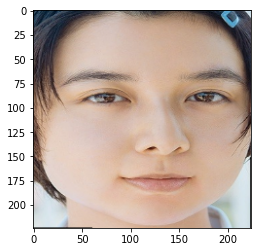

In [13]:
#Face Alignment 
from deepface import DeepFace 

detected_face = DeepFace.detectFace(similar_face)
plt.imshow(detected_face)
plt.savefig('./alignment_face/detected_face.jpg')

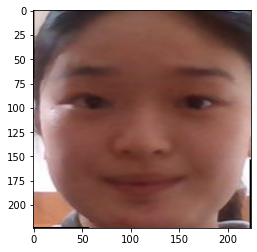

In [14]:
#Face Alignment
detected_myface = DeepFace.detectFace("picture/user_frame.jpg")
plt.imshow(detected_myface)
plt.savefig('./alignment_face/detected_myface.jpg')

In [15]:
#연예인 얼굴의 비율(x,y)포인트를 추출한다.
def createBox(img, points, scale=5):
    mask = np.zeros_like(img)
    mask = cv2.fillPoly(mask,[points],(255,255,255))
    img = cv2.bitwise_and(img, mask)
    bbox = cv2.boundingRect(points)
    x,y,w,h = bbox
    imgCrop = img[y:y+h, x:x+w]
    imgCrop = cv2.resize(imgCrop, (0,0), None, scale, scale)
    return imgCrop

img = cv2.imread("alignment_face/detected_face.jpg")
imgOriginal = img.copy()
imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = detector(imgGray)
for face in faces:
    landmarks = predictor(imgGray, face)
    mypoints = []
    for n in range(0,68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        mypoints.append([x,y])
        cv2.circle(imgOriginal, (x,y), 2, (50,50,255), -1)
        cv2.putText(imgOriginal, str(n), (x,y-10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (0,0,225),1)
    
    mypoints = np.array(mypoints)
#     imgLeftEyebrow = createBox(img, mypoints[17:22],1.5)
#     cv2.imshow('LeftEyebrow',imgLeftEyebrow)
#     imgRightEyebrow = createBox(img, mypoints[22:27],1.5)
#     cv2.imshow('RightEyebrow',imgRightEyebrow)
    imgEyebrow = createBox(img, mypoints[17:27],1.5)
    cv2.imshow('Eyebrow',imgEyebrow)
    print(mypoints)
    
cv2.imshow('Original', imgOriginal)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[115 127]
 [120 155]
 [125 180]
 [131 204]
 [144 223]
 [166 236]
 [191 243]
 [216 249]
 [238 252]
 [258 248]
 [277 240]
 [295 229]
 [308 214]
 [316 194]
 [321 172]
 [324 149]
 [325 125]
 [138 110]
 [154  98]
 [175  94]
 [196  95]
 [218 101]
 [260 101]
 [278  96]
 [295  93]
 [313  96]
 [325 108]
 [240 121]
 [242 136]
 [244 150]
 [246 165]
 [223 178]
 [234 180]
 [244 182]
 [253 180]
 [262 177]
 [167 123]
 [181 118]
 [195 117]
 [208 125]
 [194 126]
 [180 126]
 [266 125]
 [279 118]
 [292 117]
 [304 123]
 [293 126]
 [279 126]
 [197 202]
 [217 199]
 [232 196]
 [242 198]
 [251 196]
 [262 199]
 [273 203]
 [261 211]
 [250 214]
 [241 215]
 [230 214]
 [215 211]
 [204 203]
 [232 202]
 [242 204]
 [250 202]
 [268 203]
 [250 203]
 [242 204]
 [231 204]]


In [16]:
#얼굴의 크기를 맞추기 위한 0과 16번 포인트계산. 
def face_pro(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(imgGray)
    for face in faces:
        landmarks = predictor(imgGray, face)
        mypoints = []
        for n in range(0,68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            mypoints.append([x,y])
        mypoints = np.array(mypoints)
        
    right = mypoints[0]
    left = mypoints[16]
    Rx = right[0]
    Ry = right[1]
    Lx = left[0]
    Ly = left[1]
    propotion = np.sqrt((Lx - Rx)**2 + (Ly - Ry)**2)
    return mypoints, propotion

def width_cal(img, mypoints):
#눈썹 위치(픽설값)을 eyebrow list로 저장한다.
    eyebrow = []
    for i in range(17,27):
        eb = mypoints[i]
        x = eb[0]
        y = eb[1]
        eyebrow.append([x,y])
    eyebrow = np.array(eyebrow)
    print("eyebrow's points",eyebrow,sep="\n")
    
    center = mypoints[27]
    Cx = center[0]
    Cy = center[1]

# 눈썹의 중심부터 각 눈썹 포인트까지의 x,y를 구하고 position list에 저장.
    position = []
    for j in range(0,10):
        point = eyebrow[j]
        Px = point[0]
        Py = point[1]
        x = Px - Cx
        y = Py - Cy
        position.append([x,y])
    position = np.array(position)
    print("eyebrow distance points from 27",position,sep="\n")
    return position
        
model_img = cv2.imread("alignment_face/detected_face.jpg")
user_img = cv2.imread("alignment_face/detected_myface.jpg")

userpoints, user_pro = face_pro(user_img)
modelpoints, model_pro = face_pro(model_img)
pro = user_pro / model_pro
print(pro)
print("model's face size",model_pro)
print("user's face size",user_pro)

model = cv2.resize(model_img, (0,0), None, pro, pro)
modelpoints = modelpoints*pro
position = width_cal(model, modelpoints)

#사용자 얼굴 크기에 맞춰서 연예인 얼굴 크기를 조절한다.
cv2.imshow("original size", model_img)
cv2.imshow("resize model pcture", model)
cv2.imshow("user", user_img)

cv2.waitKey(0)
cv2.destroyAllWindows()

0.995461845689153
model's face size 212.0
user's face size 211.03791128610044
eyebrow's points
[[137.37373471 108.50534118]
 [154.29658608  97.55526088]
 [174.205823    93.57341349]
 [195.11052176  95.56433719]
 [217.01068236 101.53710826]
 [258.82007988 101.53710826]
 [276.7383931   96.55979903]
 [293.66124448  93.57341349]
 [311.5795577   95.56433719]
 [322.529638   106.51441749]]
eyebrow distance points from 27
[[-101.53710826  -11.94554215]
 [ -84.61425688  -22.89562245]
 [ -64.70501997  -26.87746983]
 [ -43.80032121  -24.88654614]
 [ -21.90016061  -18.91377507]
 [  19.90923691  -18.91377507]
 [  37.82755014  -23.8910843 ]
 [  54.75040151  -26.87746983]
 [  72.66871474  -24.88654614]
 [  83.61879504  -13.93646584]]


In [8]:
#사용자 눈썹의 중심부터 계산한 연예인의 눈썹 포인트를 반영시킨다.
def Detect(mypoints):
    center = mypoints[27]
    Cx = center[0]
    Cy = center[1]
    print("center point",center,sep="\n")
    
    newpoints = []
    for i in range(0,10):
        x = Cx + position[i][0]
        y = Cy + position[i][1]
        newpoints.append([x,y])
    newpoints = np.array(newpoints)
    print("eyebrow new points",newpoints,sep="\n")
    return newpoints

print("original eyebrow points",userpoints[17:28],sep="\n")
newpoints = Detect(userpoints)
print("destance from center point of model",position,sep="\n")

original eyebrow points
[[133  99]
 [147  89]
 [166  88]
 [185  91]
 [203  98]
 [238  98]
 [258  90]
 [279  88]
 [299  91]
 [314 102]
 [221 122]]
center point
[221 122]
eyebrow new points
[[119.46289174 110.05445785]
 [136.38574312  99.10437755]
 [156.29498003  95.12253017]
 [177.19967879  97.11345386]
 [199.09983939 103.08622493]
 [240.90923691 103.08622493]
 [258.82755014  98.1089157 ]
 [275.75040151  95.12253017]
 [293.66871474  97.11345386]
 [304.61879504 108.06353416]]
destance from center point of model
[[-101.53710826  -11.94554215]
 [ -84.61425688  -22.89562245]
 [ -64.70501997  -26.87746983]
 [ -43.80032121  -24.88654614]
 [ -21.90016061  -18.91377507]
 [  19.90923691  -18.91377507]
 [  37.82755014  -23.8910843 ]
 [  54.75040151  -26.87746983]
 [  72.66871474  -24.88654614]
 [  83.61879504  -13.93646584]]


In [9]:
imgOrigin = user_img.copy()
imgGray = cv2.cvtColor(user_img, cv2.COLOR_BGR2GRAY)
faces = detector(imgGray)
for face in faces:
    landmarks = predictor(imgGray, face)
    mypoints = []
    for n in range(0,68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        mypoints.append([x,y])
    mypoints = np.array(mypoints)
    mypoints[17:27], newpoints[0:10] = newpoints[0:10], mypoints[17:27]
    print(mypoints)
    
    for i in range(17,27):
        x = mypoints[i][0]
        y = mypoints[i][1]
        cv2.circle(imgOrigin, (x,y), 2, (50,50,255), -1)
    
cv2.imshow('recommend eyebrow points', imgOrigin)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[121 110]
 [122 135]
 [124 159]
 [127 183]
 [136 206]
 [151 224]
 [172 238]
 [196 249]
 [223 253]
 [250 249]
 [276 239]
 [300 225]
 [317 208]
 [326 184]
 [330 158]
 [332 133]
 [332 106]
 [119 110]
 [136  99]
 [156  95]
 [177  97]
 [199 103]
 [240 103]
 [258  98]
 [275  95]
 [293  97]
 [304 108]
 [221 122]
 [221 137]
 [221 151]
 [221 166]
 [199 178]
 [210 181]
 [221 183]
 [233 181]
 [244 179]
 [151 125]
 [165 121]
 [179 121]
 [192 129]
 [179 131]
 [164 130]
 [253 129]
 [266 122]
 [280 121]
 [294 125]
 [281 131]
 [266 131]
 [180 202]
 [199 199]
 [212 196]
 [222 198]
 [233 196]
 [248 199]
 [267 201]
 [248 215]
 [232 221]
 [221 222]
 [211 221]
 [197 216]
 [187 203]
 [212 205]
 [222 206]
 [232 205]
 [260 202]
 [232 209]
 [222 210]
 [211 210]]


In [21]:
cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        for n in range(27,28):
            realx = landmarks.part(n).x
            realy = landmarks.part(n).y
            cv2.circle(frame, (realx, realy), 2, (0, 255, 0), -1)
            for i in range(0,10):
                x = realx + position[i][0]
                y = realy + position[i][1]
                x = int(x)
                y = int(y)
                cv2.circle(frame, (x, y), 2, (0, 0, 255), -1)
    
    frame = cv2.flip(frame, 1)
    cv2.imshow("Frame", frame)
    
    key = cv2.waitKey(1)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# #　try cosoin similality

# #Aspect Ratio,comparison of face length and width.The wider the width, the higher the value
# def fwhrs(parts):
#     height = ((parts[8].x - parts[27].x) ** 2 + (parts[8].y - parts[27].y) ** 2) ** 0.5
#     width = ((parts[16].x - parts[0].x) ** 2 + (parts[16].y - parts[0].y) ** 2) ** 0.5
#     fwhr = width/height
#     return round(fwhr, 3)

# #the ratio of the distance between the eyebrow and the nose, the nose and the tip of the chin
# def heights(parts):
#     top_height = ((parts[33].x - parts[27].x) ** 2 + (parts[33].y - parts[27].y) ** 2) ** 0.5
#     bottom_height =((parts[8].x - parts[33].x) ** 2 + (parts[8].y - parts[33].y) ** 2) ** 0.5
#     return top_height,bottom_height

# #distance from the edge of the face to the corner of the left eye.....etc.
# def widths(parts):
#     left_face = ((parts[16].x - parts[45].x) ** 2 + (parts[16].y - parts[45].y) ** 2) ** 0.5
#     left_eye = ((parts[45].x - parts[42].x) ** 2 + (parts[45].y - parts[42].y) ** 2) ** 0.5
#     middle_face = ((parts[42].x - parts[39].x) ** 2 + (parts[42].y - parts[39].y) ** 2) ** 0.5
#     right_eye = ((parts[39].x - parts[36].x) ** 2 + (parts[39].y - parts[36].y) ** 2) ** 0.5
#     right_face = ((parts[36].x - parts[0].x) ** 2 + (parts[36].y - parts[0].y) ** 2) ** 0.5
#     return left_face, left_eye, middle_face, right_eye,right_face

# #distance between nose and lower lip, distance between the lower lip and the tip of the chin
# def mouses(parts):
#     top_mouse = ((parts[57].x - parts[33].x) ** 2 + (parts[57].y - parts[33].y) ** 2) ** 0.5
#     bottom_mouse = ((parts[8].x - parts[57].x) ** 2 + (parts[8].y - parts[57].y) ** 2) ** 0.5
#     return top_mouse, bottom_mouse

# #make data frame
# df = pd.DataFrame()

# #figure out the ratio
# for file_name in os.listdir('picture'):
#     if file_name[-4:] != '.jpg':
#         continue
    
#     if file_name == "user_frame.jpg": continue
    
#     frame = cv2.imread('picture/'+file_name)
#     dets = detector(frame[:, :, ::-1])
#     if len(dets) > 0:
#         parts = predictor(frame, dets[0]).parts()
#         fwhr = fwhrs(parts)  
#         top_height,bottom_height = heights(parts)
#         left_face, left_eye, middle_face, right_eye,right_face = widths(parts)
#         top_mouse, bottom_mouse = mouses(parts)
#         t_dict = {'name':[file_name.replace('.jpg','')],
#                   'fwhr':[fwhr],
#                   'top_height':[top_height],
#                   'bottom_height':[bottom_height],
#                   'left_face':[left_face],
#                   'left_eye':[left_eye],
#                   'middle_face':[middle_face],
#                   'right_eye':[right_eye],
#                   'right_face':[right_face],
#                   'top_mouse':[top_mouse],
#                   'bottom_mouse':[bottom_mouse]}
#         tmp = pd.DataFrame(t_dict)
#         df = pd.concat([df,tmp])
#         #Y = np.array([df['Height-Ratio'], df['Width-Ratio1'], df['Width-Ratio2'], df['Width-Ratio3'], df['Width-Ratio4'], df['Mouse-Ratio']])

# file_name = 'user_frame.jpg'
# frame = cv2.imread('picture/'+file_name)
# parts = predictor(frame, dets[0]).parts()
# fwhr = fwhrs(parts)  
# top_height,bottom_height = heights(parts)
# left_face, left_eye, middle_face, right_eye,right_face = widths(parts)
# top_mouse, bottom_mouse = mouses(parts)
# #replace　no"jpg"! yes space!
# t_dict = {'name':[file_name.replace('.jpg','')],
#           'fwhr':[fwhr],
#           'top_height':[top_height],
#           'bottom_height':[bottom_height],
#           'left_face':[left_face],
#           'left_eye':[left_eye],
#           'middle_face':[middle_face],
#           'right_eye':[right_eye],
#           'right_face':[right_face],
#           'top_mouse':[top_mouse],
#           'bottom_mouse':[bottom_mouse]}

# # calculate user face
# user_ratio = pd.DataFrame(t_dict)
# user_ratio['Height-Ratio'] = user_ratio['top_height']/user_ratio['bottom_height']
# user_ratio['Width-Ratio1'] = user_ratio['left_face']/user_ratio['middle_face']
# user_ratio['Width-Ratio2'] = user_ratio['left_eye']/user_ratio['middle_face']
# user_ratio['Width-Ratio3'] = user_ratio['right_eye']/user_ratio['middle_face']
# user_ratio['Width-Ratio4'] = user_ratio['right_face']/user_ratio['middle_face']
# user_ratio['Mouse-Ratio'] = user_ratio['top_mouse']/user_ratio['bottom_mouse']

# df['Height-Ratio'] = df['top_height']/df['bottom_height']
# df['Width-Ratio1'] = df['left_face']/df['middle_face']
# df['Width-Ratio2'] = df['left_eye']/df['middle_face']
# df['Width-Ratio3'] = df['right_eye']/df['middle_face']
# df['Width-Ratio4'] = df['right_face']/df['middle_face']
# df['Mouse-Ratio'] = df['top_mouse']/df['bottom_mouse']


# def cos_sim(v1, v2):
#     sum = 0
#     for x,y in zip(v1,v2):
#         sum += np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
#     return  sum/len(v1)

# sim_num = 0
# sim_result = 0
# X = np.array([user_ratio['Height-Ratio'], user_ratio['Width-Ratio1'], user_ratio['Width-Ratio2'], user_ratio['Width-Ratio3'], user_ratio['Width-Ratio4'],user_ratio['Mouse-Ratio']])
# for i in range(len(df)):
#     Y = np.array([df[i:i+1]['Height-Ratio'], df[i:i+1]['Width-Ratio1'], df[i:i+1]['Width-Ratio2'], df[i:i+1]['Width-Ratio3'], df[i:i+1]['Width-Ratio4'], df[i:i+1]['Mouse-Ratio']])
#     print(X)
#     print(Y)
#     print(cos_sim(X, Y))
    
#     if sim_result < cos_sim(X, Y):
#         sim_result = cos_sim(X, Y)
#         sim_num = i